# PART 1 : Text detection using OpenCV

### Based on OpenCV's EAST deep learning text detector

EAST Original paper: https://arxiv.org/abs/1704.03155

EAST means Efficient and Accurate Scene Text detection pipeline. The EAST pipeline is capable of predicting words and lines of text at arbitrary orientations on 720p images, and furthermore, can run at 13 FPS, according to the authors.

# PART 2 : Text recognition 
### Based on Tesseract. In this we will take each of the area containing text identified above and actually recognize and OCR the text using OpenCV and tesseract

Tesseract v4 is highly accurate deep learning based model for text recognition. 


Tesseract downloaded and installed from link: https://github.com/UB-Mannheim/tesseract/wiki



# PART 1 : Text detection

Create bounding box around text (called ROI)

In [1]:
# require opencv version 3.4.2 or opencv 4 
import cv2
print(cv2.__version__)

4.1.2


# Step 1 : Import Libraries

In [18]:
# import required libraries
from imutils.object_detection import non_max_suppression
import numpy as np
import pandas as pd
import argparse
import time
import cv2
import os

from matplotlib import pyplot as plt
%matplotlib inline


# Step 2 : Load image and resize it

In [1]:
# setup input arguments. These will be used when calling as a script. 
# Disabled in notebook.

# contruct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument('-i', '--image', type=str, help='path to input image')
# ap.add_argument('-east', '--east', type=str, help='path to input EAST text detector')
# ap.add_argument('-c', '--min_confidence', type=float, default=0.5, 
#                 help='minimum probability required to inspect a regions')
# ap.add_argument('-w', '--width', type=int, default=320,
#                 help='resized image width (should be multiple of 32)')
# ap.add_argument('-e', '--height', type=int, default=320,
#                 help='resized image height (should be multiple of 32)')
# ap.add_argument('-p','--padding', type=float, default=0.0, 
#                 help='amount of padding to add to each border of ROI')
# args = vars(ap.parse_args())

# args_image = args['image']
# args_east = args['east']
# args_min_confidence = args["min_confidence"]
# args_width = args['width']
# args_height = args['height']
# args_padding = args['padding']

In [19]:
# since args does not work in notebook, so setting up custom values:
image_path = ".\\data\\images\\" 
args_image = os.path.join(image_path,'car_wash.png')
args_east = '.\\EAST\\frozen_east_text_detection.pb'
args_min_confidence = 0.5
args_width = 320
args_height = 320

# used in part2. We can try with 0.05 for 5% or 0.1 for 10% 
# if found that OCR results are incorrect
args_padding = 0.0 

### Important: The EAST text requires that your input image dimensions be multiples of 32, so if you choose to adjust your --width  and --height  values, make sure they are multiples of 32!

### Lets load a image and resize it

In [20]:
# load input image and grab its dimension
#image = cv2.imread(args['image'])
image = cv2.imread(args_image)
orig = image.copy()
(origH, origW) = image.shape[:2]

# set the new width and height and determine the ratio in change. 
# also called resize factor
#(newH, newW) = (args['height'], args['width'])
(newH, newW) = (args_height, args_width)
rH = origH / float(newH)
rW = origW / float(newW)

# resize the image and grab new dimension
image = cv2.resize(image, (newW, newH))
(H, W) = image.shape[:2]


# Step 3 : Load OpenCV EAST text detector and extract features

### In order to perform text detection using OpenCV and the EAST deep learning model, we need to extract the output feature maps of two layers:

#### Define the two output layer names for the EAST detector model that we are interested -- 
- First is the output probabilities. This layer is our output activation which gives us the probability of a region containing text or not.
- Second can be used to derive the bounding box coordinates of text. Second layer is the output feature man that represents the "geometry" of the image. We will be able to use this geometry to derive the bounding box coordnates of the text in input image

### Lets load OpenCV EAST text detector

In [21]:
layerNames = ['feature_fusion/Conv_7/Sigmoid', # probability of region containing text
              'feature_fusion/concat_3']       # geometry feature map to use for bounding box

# load the pre-trained EAST text detector
print('[INFO] loading EAST text detector...')

# load neuralnet into memory by passing the path of EAST detector
#net = cv2.dnn.readNet(args['east'])
net = cv2.dnn.readNet(args_east)



[INFO] loading EAST text detector...


In [55]:
net.getLayerNames()

['resnet_v1_50/conv1/Conv2D',
 'resnet_v1_50/conv1/BatchNorm/FusedBatchNorm',
 'resnet_v1_50/conv1/Relu',
 'resnet_v1_50/pool1/MaxPool',
 'resnet_v1_50/block1/unit_1/bottleneck_v1/conv1/Conv2D',
 'resnet_v1_50/block1/unit_1/bottleneck_v1/conv1/BatchNorm/FusedBatchNorm',
 'resnet_v1_50/block1/unit_1/bottleneck_v1/conv1/Relu',
 'resnet_v1_50/block1/unit_1/bottleneck_v1/conv2/Conv2D',
 'resnet_v1_50/block1/unit_1/bottleneck_v1/conv2/BatchNorm/FusedBatchNorm',
 'resnet_v1_50/block1/unit_1/bottleneck_v1/conv2/Relu',
 'resnet_v1_50/block1/unit_1/bottleneck_v1/conv3/Conv2D',
 'resnet_v1_50/block1/unit_1/bottleneck_v1/conv3/BatchNorm/FusedBatchNorm',
 'resnet_v1_50/block1/unit_1/bottleneck_v1/shortcut/Conv2D',
 'resnet_v1_50/block1/unit_1/bottleneck_v1/shortcut/BatchNorm/FusedBatchNorm',
 'resnet_v1_50/block1/unit_1/bottleneck_v1/add',
 'resnet_v1_50/block1/unit_1/bottleneck_v1/Relu',
 'resnet_v1_50/block1/unit_2/bottleneck_v1/conv1/Conv2D',
 'resnet_v1_50/block1/unit_2/bottleneck_v1/conv1/Bat

In [22]:
# construct a blob from the image and then perform a forward pass of 
# the model to obtain the two output layer set

# convert input image to blob
# more info at: https://www.pyimagesearch.com/2017/11/06/deep-learning-opencvs-blobfromimage-works/
blob = cv2.dnn.blobFromImage(image, 
                             1.0,
                             (W, H),
                             (123.68, 116.78, 103.94),
                             swapRB=True,
                             crop=False )

start = time.time()

# to preduct text, we can simply set the blob as input and call net.forward
# by supplying layerNames as parameter to net.forward we are instructing openCV to return
# the two feature maps
# output geometry used to derive bounding box coordinates of text in input image
# output scores contains the probability of given region containing text
net.setInput(blob)
(scores, geometry) = net.forward(layerNames)
end = time.time()

# showing timing information on text prediction
print('[INFO] text detection took {:6f} seconds'.format(end - start))

[INFO] text detection took 0.289151 seconds


In [31]:
scores[0][0][0]

array([2.75855399e-07, 3.10657171e-08, 8.75323458e-09, 9.26292643e-09,
       3.11155297e-08, 1.71134698e-08, 1.42275356e-08, 2.89382172e-08,
       1.25376445e-07, 3.05122470e-08, 2.71369527e-09, 3.88530585e-09,
       1.93947276e-08, 1.06008969e-07, 1.66020001e-07, 7.86037262e-08,
       1.24889032e-08, 6.11942008e-09, 5.43576384e-09, 1.11943610e-08,
       2.28933228e-08, 2.79769274e-08, 2.82192723e-08, 7.49332756e-08,
       1.90170311e-07, 3.11923685e-07, 2.85017506e-07, 2.24259011e-07,
       2.35417815e-07, 2.94083719e-07, 2.87496277e-07, 1.78629051e-07,
       1.39694777e-07, 1.19624431e-07, 1.12944811e-07, 1.27260506e-07,
       2.43178647e-07, 3.88655764e-07, 5.93873267e-07, 2.71585890e-07,
       1.57121775e-07, 1.03511418e-07, 1.28150177e-07, 1.42173960e-07,
       6.89589896e-08, 5.57582673e-08, 4.11579002e-08, 6.01194614e-08,
       4.96614376e-08, 2.36746551e-08, 2.97303728e-08, 1.31844464e-08,
       6.51897336e-09, 1.73730808e-09, 2.06360440e-09, 1.95250820e-08,
      

In [34]:
geometry[0][0][0]

array([158.71123 , 120.85707 , 132.92189 , 139.24397 , 151.64001 ,
       159.47675 , 151.33202 , 129.88263 , 107.00956 ,  94.53418 ,
        89.28628 ,  84.075584,  76.11836 ,  71.246475,  71.717354,
        72.63356 ,  79.06255 ,  86.390045,  92.44936 ,  96.230354,
        98.39055 ,  97.43121 ,  95.77277 ,  90.96292 ,  90.64121 ,
        95.60738 , 100.19536 , 107.25515 , 113.15102 , 114.0995  ,
       114.67177 , 113.21679 , 108.58429 , 102.13174 ,  95.797676,
        88.90994 ,  83.108696,  79.14443 ,  77.33516 ,  77.359955,
        76.47795 ,  76.513306,  80.12247 ,  82.8722  ,  86.85227 ,
        90.261826,  91.98478 ,  89.52821 ,  80.2902  ,  72.9663  ,
        69.55799 ,  66.213036,  66.676254,  65.166695,  60.250015,
        56.609695,  53.85211 ,  52.598877,  52.02346 ,  52.517715,
        53.244373,  53.805977,  55.91574 ,  54.857162,  56.1389  ,
        56.94149 ,  54.206757,  54.940014,  57.187206,  58.903244,
        59.624844,  60.28915 ,  61.79815 ,  62.02361 ,  62.080

# Step 4 : Loop thru features and keep strong overlapping bounding boxes only

### Lets loop over each of the output values, one-by-one

In [55]:
scores.shape, geometry.shape

((1, 1, 80, 80), (1, 5, 80, 80))

In [23]:
# grab the number of rows and columns from the scores volume,
# then initialize our set of bounding box rectangles and
# corresponding confidence scores
(numRows, numCols) = scores.shape[2:4]
rects = []        # list to store the bounding box (x,y) coordinates for text regions
confidences = []  # list to store the porbabilities associated with each bounding box in rects
print(numRows, numCols)

# loop over the number of rows
for y in range(numRows):
#for y in range(1):
    # extract the scores (probabilities), followed by the geometrical 
    # data used to derive potential bounding box coordinates that 
    # surround text
    # get once score row (it has numCols values)
    scoresData = scores[0, 0, y]
    # get its bounding box values
    xData0 = geometry[0, 0, y]
    xData1 = geometry[0, 1, y]
    xData2 = geometry[0, 2, y]
    xData3 = geometry[0, 3, y]
    angleData = geometry[0, 4, y]
    
    #print(y)
    #print(scoresData)
    #print(xData0)
    #print(xData1)
    #print(xData2)
    #print(xData3)
    #print(angleData)
    
    # loop thru each numCols values to check if it meets minimum probability criteria
    for x in range(numCols):
        # check if the value has sufficient probability
        #print(x)
        #print(scoresData[x])
        #if scoresData[x] < args["min_confidence"]:
        if scoresData[x] < args_min_confidence:
            continue    # go to next value in loop
        
        # compute the offset factor as our resulting feeatures maps
        # will be 4x smaller than the input image
        (offsetX, offsetY) = (x*4.0, y*4.0)
        
        # extract the rotation angle for the prediction and then
        # compute the sin and cosine
        angle = angleData[x]
        cos = np.cos(angle)
        sin = np.sin(angle)
        
        # use the geometry volume to derive the width and height of the bounding box
        h = xData0[x] + xData2[x]
        w = xData1[x] + xData3[x]
        
        # compute both the starting and ending (x,y) coordinates
        # for the text prediction bounding box
        endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
        endY = int(offsetY + (sin * xData1[x]) + (cos * xData2[x]))
        startX = int(endX - w)
        startY = int(endY - h)
        
        # append the bounding box xoordinates and probability score to list
        #print(scoresData[x],startX, startY, endX, endY)
        rects.append((startX, startY, endX, endY))
        confidences.append(scoresData[x])


len(rects), len(confidences)

80 80


(71, 71)

### Do not execute below

In [16]:
# # read in one of the comments that bounding box on rotated text does not elcose all of the text. 
# # So below one should help. But I have not tried it
# # it replaces rows calculating endX, endY, startX, startY above

# # A more accurate bounding box for rotated text
# offsetX = offsetX + cos * xData1[x] + sin * xData2[x] 
# offsetY = offsetY - sin * xData1[x] + cos * xData2[x]                
        
# # calculate the UL and LR corners of the bounding rectangle
# p1x = -cos * w + offsetX
# p1y = -cos * h + offsetY
# p3x = -sin * h + offsetX
# p3y = sin * w + offsetY
                           
# # add the bounding box coordinates
# rects.append((p1x, p1y, p3x, p3y))



### IMP: The EAST text detector naturally reduces volume size as the image passes through the network — our volume size is actually 4x smaller than our input image so we multiply by four to bring the coordinates back into respect of our original image.
### The final step is to apply non-maxima suppression to our bounding boxes to suppress weak overlapping bounding boxes and then display the resulting text predictions:

In [24]:
# apply non-maxima suppresion to suppress weak, overlapping bounding boxes
boxes = non_max_suppression(np.array(rects), probs=confidences)
print(boxes.shape[0],' bounding box detected')

3  bounding box detected


In [25]:
boxes.shape, len(rects), len(confidences)

((3, 4), 71, 71)

In [8]:
#rects

In [58]:
boxes

array([[ 55,   9, 101,  28],
       [104,  12, 149,  36],
       [155,  13, 219,  36]])

# Step 5 : Show final image
### Scale bounding box coordinates per scaling factor to original image size

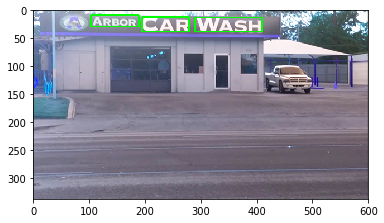

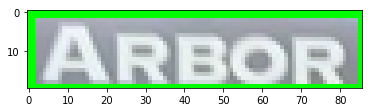

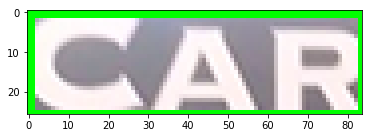

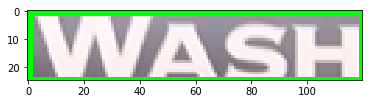

In [26]:
# list to store bounding box area containing text
roi = []

# loop over the bounding boxes
for (startX, startY, endX, endY) in boxes:
    
    #print(startX, startY, endX, endY) 
    # scale the bounding box coordinates based on the respective ratios
    startX = int(startX * rW)
    startY = int(startY * rH)
    endX = int(endX * rW)
    endY = int(endY * rH)
    #print('scaled: ',startX, startY, endX, endY) 
    
    # draw the bounding box on image
    cv2.rectangle(orig, (startX, startY), (endX, endY), (0,255,0), 2)
    
    # extract each bounding box area
    roi.append(orig[startY:endY, startX:endX])    
    
    
# show the output image
# cv2 shows image in popup
#cv2.imshow('Text Detection', orig)
#cv2.waitKey(0)
# plt shows image inline
plt.imshow(orig)
plt.show()

for img_part in roi:
    plt.imshow(img_part)
    plt.show()

# PART 2 : Text recognition

In PART1, we applied OpenCV EAST text detector to detect the presence of text in an image. It gives us the bounding box (x,y) coordinates of the text ROIs. 

In this step, we will extract each of those ROIs and pass them into Tessaract LSTM deep learning text recognition algorithm. The output of LSTM will give us actual OCR results. 

Then in last step we will draw OCR results on our actual image. 

When calling Tesseract command (which will be called under the hood by the pytesseract library), we need to supply a number of flags. Three most important ones are:
- -l : it controls the language of input text. We will be using eng (engligh) for this example but tesseract supports many other languages. Link: https://github.com/tesseract-ocr/tesseract/wiki/Data-Files
- --oem : known as OCR engine mode, it controls the type of algorithm used by tesseract. 
- --psm : It controls the automatic page segmentation mode used by tesseract




In [27]:
import pytesseract
#pytesseract.pytesseract.tesseract_cmd = 'C:\\Users\\yadav\\Desktop\\tesseract.exe'
pytesseract.pytesseract.tesseract_cmd = 'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'

### Modified ROI extraction part from above to including padding

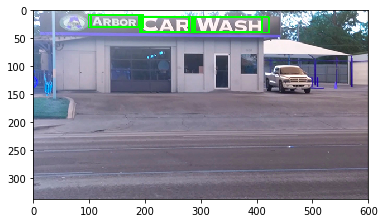

In [28]:
# list to store bounding box area containing text
#roi = []
# and final tesseract results
results = []

# loop over the bounding boxes
for (startX, startY, endX, endY) in boxes:
    
    #print(startX, startY, endX, endY) 
    # scale the bounding box coordinates based on the respective ratios
    startX = int(startX * rW)
    startY = int(startY * rH)
    endX = int(endX * rW)
    endY = int(endY * rH)
    #print('scaled: ',startX, startY, endX, endY) 
    
    # image ad roi without padding
    # draw the bounding box on image
    #cv2.rectangle(orig, (startX, startY), (endX, endY), (0,255,0), 2)
    # extract each bounding box area
    #roi.append(orig[startY:endY, startX:endX]) 
    #roi = orig[startY:endY, startX:endX]
    
    # In order to obtain a better OCR of the texxt we can potentially apply 
    # a bit of padding surrounding the bounding box. 
    # here we are computing the deltas in both the x and y directions
    args_padding = 0.05
    dX = int((endX - startX) * args_padding)
    dY = int((endY - startY) * args_padding)
    
    # apply padding on each side of bounding box, respectively
    startX = max(0, startX - dX)
    startY = max(0, startY - dY)
    endX = min(origW, endX + (dX * 2))
    endY = min(origH, endY + (dY * 2))
    #print('padded: ',startX, startY, endX, endY) 
    
    # draw bounding box on image
    cv2.rectangle(orig, (startX, startY), (endX, endY), (0,255,0), 2)
    
    # extract the actual padded ROI
    roi = orig[startY:endY, startX:endX]
    #plt.imshow(roi)
    #plt.show()
    
    # now that we have extracted ROI (bounding box), 
    # we will pass this part of image tesseract to extract text. 
    # in order to aupply Tesseract to OCR text, we will set few parameter required for it. 
    # -l (language) to english
    # -oem flag of 4 indicating that we wish to use LSTM neural net model for OCR
    # -psm value of 7 which implies that we are treating the ROI as a single line or text
    config = ("-l eng --oem 1 --psm 7")
    text = pytesseract.image_to_string(roi, config=config)
    #print('test: ',text)
    # in just 2 lines of code, we have used tesseract to recognize a text from an image. 
    # but there is lot happening under the hood. 
    
    # add the bounding box coordinates and OCR returned text to the list
    results.append(((startX, startY, endX, endY), text))
    


# cv2 shows image in popup
#cv2.imshow('Text Detection', orig)
#cv2.waitKey(0)
# plt shows image inline
plt.imshow(orig)
plt.show()

# for img_part in roi:
#     plt.imshow(img_part)
#     plt.show()

In [29]:
# display the results and bounding box on the image
# sort the results bounding box coordinates from the top to bottom
results = sorted(results, key=lambda r:r[0][1])

output = orig.copy()
# loop over the results
for ((startX, startY, endX, endY), text) in results:
    # display thee text OCR given by tesseract
    print('OCR Text')
    print('--------')
    print('{}\n'.format(text))
    
    # strip out non-ASCII text so we can draw the text on the image
    # using OpenCV, then draw the text and a bounding box surrounding the text region
    text = ''.join([c if ord(c) < 128 else '' for c in text]).strip()
    #output = orig.copy()
    cv2.rectangle(output, (startX, startY), (endX, endY), (0,0,255),2)
    cv2.putText(output, text, (startX, startY - 20), 
                cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0,0,255),3)
    
    # show the output image
    #cv2.imshow('Text detection', output)
    #cv2.waitKey(0)
    #plt.imshow(output)
    #plt.show()
    
    
cv2.imshow('Text detection', output)
cv2.waitKey(0)
#plt.imshow(output)
#plt.show()

    

OCR Text
--------
‘ARBGR |

OCR Text
--------
CAR

OCR Text
--------
WASH



113